## Forecasting Hourly Energy Consumption with LightGBM¶
Light Gradient Boosting is a method of tree boosting that differs from XGBoost in one primary way. LightGBM grows trees leaf-wise, rather than level-wise as would other gradient boosting methods.

Notebook found at: https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost/data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import math
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
foo =r'C:\Users\ACER\Desktop\python project\airqo/BugolobiHOULY.csv'

In [5]:
pjme = pd.read_csv(foo, index_col=[0], parse_dates=[0])

In [6]:
pjme.head(5)

,s2_pm2_5
Date,
2019-03-12 09:00:00,19.975000
2019-03-12 11:00:00,15.408571
2019-03-12 12:00:00,14.654348
2019-03-12 13:00:00,14.365435
2019-03-12 14:00:00,15.451739


In [7]:
len(pjme)

179

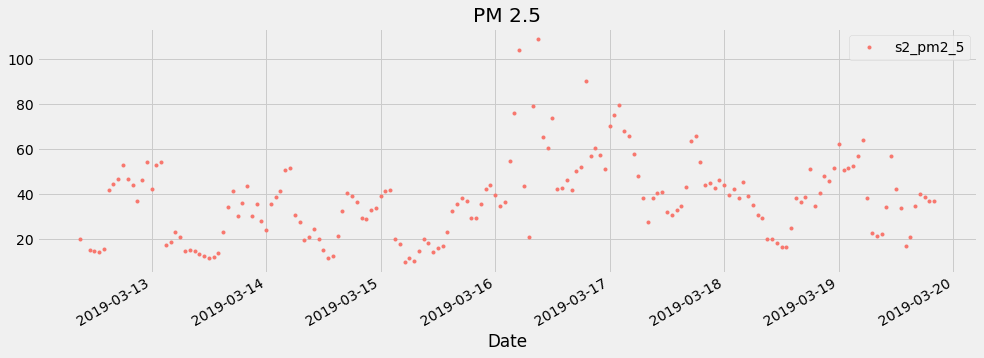

In [8]:
# Plotting timeseries
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
temp_plot = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PM 2.5')

# Train/Test Split

In [9]:
split_date = '18-03-2019'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

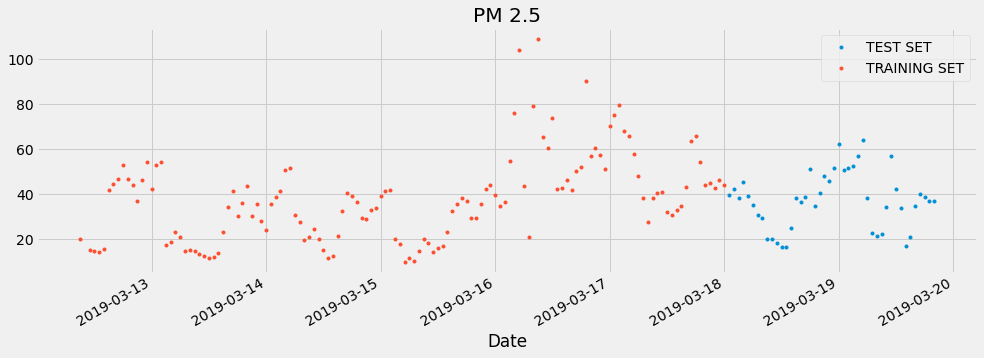

In [10]:
temp_plot = pjme_test \
    .rename(columns={'s2_pm2_5': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'s2_pm2_5': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PM 2.5', style='.')

# Create Features

In [11]:
def create_lagged_features(df, lag_count):
    """Creates lagged features"""
    # lag_count should be the number of lags to create
    
    for i in range(0, lag_count):
        df['t-{}'.format(i+1)] = df['s2_pm2_5'].shift(i+1)

    return df

In [15]:
def create_features(df, label=None):
    """Creates time series from a datetime index"""
    df['Date'] = df.index
    df['hour'] = df['Date'].dt.hour
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.weekofyear
    
   

 # Lagged Features
    
    df = create_lagged_features(df, lag_count)
    
    column_set = ['hour','dayofweek','quarter','month','year',
                   'dayofyear','dayofmonth','weekofyear']
    
    for i in range(0, lag_count):
        column_set.append('t-{}'.format(i+1))
    
    X = df[column_set]
    
    if label:
        y = df[label]
        # Drop first N (not enough lagged variables)
        X = X[lag_count:]
        y = y[lag_count:]
        return X, y
    
    # Drop first N (not enough lagged variables)
    X = X[lag_count:]
    
    return X

In [16]:
lag_count = 2

X_train, y_train = create_features(pjme_train, lag_count, label='s2_pm2_5')
X_test, y_test = create_features(pjme_test, lag_count, label='s2_pm2_5')

TypeError: create_features() got multiple values for argument 'label'